In [39]:
import tensorflow as tf
import numpy as np
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
env = gym.make("Breakout-v0")

[2017-06-25 12:01:36,636] Making new env: Breakout-v0


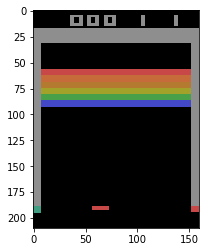

In [137]:
s = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for i in range(200):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    a = env.action_space.sample()
    s1, r, d, _ = env.step(a)
    if d==True:
        break

In [138]:
s.shape

(210, 160, 3)

In [208]:
h_size = 512
tf.reset_default_graph()

inputs = tf.placeholder(dtype=tf.float32, shape=[None, 100800])
imgs = tf.reshape(inputs, shape=[-1, 210, 160, 3])
conv1 = tf.layers.conv2d(imgs, filters=32, kernel_size=8, strides=4, padding='VALID', bias_initializer=None)
conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=4, strides=2, padding='VALID', bias_initializer=None)
conv3 = tf.layers.conv2d(conv2, filters=128, kernel_size=2, strides=1, padding='VALID', bias_initializer=None)
conv4 = tf.layers.conv2d(conv3, filters=512, kernel_size=1, strides=1, padding='VALID', bias_initializer=None)

streamAC, streamVC = tf.split(conv4, 2, 3)
streamA = tf.contrib.layers.flatten(streamAC)
streamV = tf.contrib.layers.flatten(streamVC)
A = tf.layers.dense(streamA, env.action_space.n, use_bias=False)
V = tf.layers.dense(streamV, 1, use_bias=False)

Qout = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keep_dims=True))
predict = tf.argmax(Qout, axis=1)

targetQ = tf.placeholder(dtype=tf.float32, shape=[None])
actions = tf.placeholder(dtype=tf.int32, shape=[None])
actions_onehot = tf.one_hot(actions, env.action_space.n, dtype=tf.float32)

Q = tf.reduce_sum(tf.multiply(Qout, actions_onehot), axis=1)
loss = tf.square(tf.reduce_sum(Q - targetQ))
optmize = tf.train.AdamOptimizer(learning_rate=0.001)
update = optmize.minimize(loss)

In [141]:
np.random.choice(buff, 3, replace=False)

ValueError: a must be 1-dimensional

In [211]:
from collections import deque
buff = deque(maxlen=5000)
num_episode = 1000
num_exp = 1000
e = 0.8
init = tf.global_variables_initializer()
total_step = 0

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episode):
        s = env.reset()
        s = np.reshape(s, -1)
        for j in range(num_exp):
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = sess.run(predict, feed_dict={inputs:[s]})[0]
            s1, r, d, _ = env.step(a)
            s1 = np.reshape(s1, -1)
            buff.append(np.array([s,a,r,s1]))
            s = s1
            total_step += 1
            
            # update the Qnetwork
            if total_step % 50 == 0:
                pass

KeyboardInterrupt: 

In [212]:
total_step

311118